# Lab session 1: Gaussian Process Regression Models with GPy

Gaussian Process Summer School, 14th Semptember 2015

written by Nicolas Durrande, Neil Lawrence and James Hensman

The aim of this lab session is to illustrate the concepts seen during the lectures. We will focus on three aspects of GPs: the kernel, the random sample paths and the GP regression model.

## 1 Getting started: The Covariance Function

We assume that GPy is already installed on your machine. You can get instructions on how to install GPy from the  [SheffieldML github page](https://github.com/SheffieldML/GPy). They are written as markdown in the README.md file, which is automatically parsed for you just under the file listing there.

We first tell the ipython notebook that we want the plots to appear inline, then we import the libraries we will need:

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy

The current draft of the online documentation of GPy is available from [this page](http://gpy.readthedocs.org/en/latest/).

Let's start with defining an exponentiated quadratic covariance function (also known as squared exponential or rbf or Gaussian) in one dimension:

In [2]:
d = 1          # input dimension
var = 1.       # variance
theta = 0.2    # lengthscale
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)

A summary of the kernel can be obtained using the command `print k`. 

In [3]:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.2  |      +ve      |        


It is also possible to plot the kernel as a function of one of its inputs (whilst fixing the other) with `k.plot()`. 

*Note*: if you need help with a command in ipython notebook, then you can get it at any time by typing a question mark after the command, e.g. `k.plot?`

{'covariance': [[<matplotlib.lines.Line2D at 0x19d493dafd0>]]}

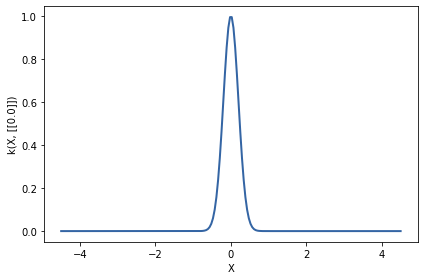

In [4]:
k.plot()

## Setting Covariance Function Parameters

The value of the covariance function parameters can be accessed and modified using `k['.*var']` where the string in bracket is a regular expression matching the parameter name as it appears in `print k`. Let's use this to get an insight into the effect of the parameters on the shape of the covariance function. 

We'll now use to set the lengthscale of the covariance to different values, and then plot the resulting covariance using the `k.plot()` method.

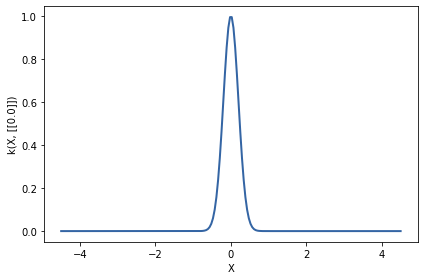

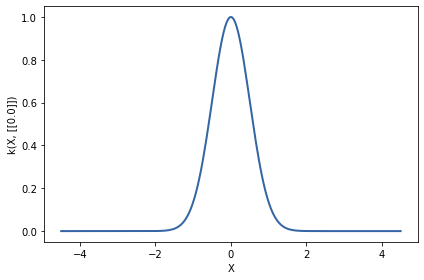

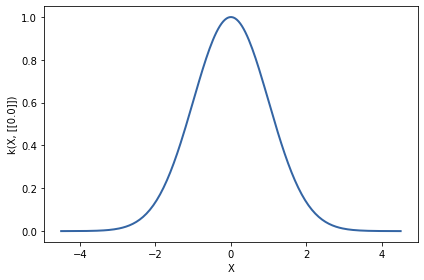

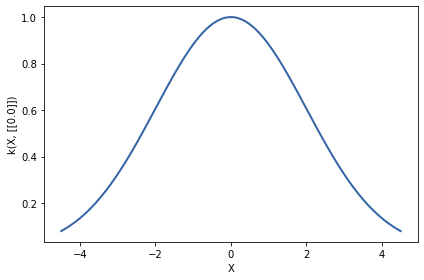

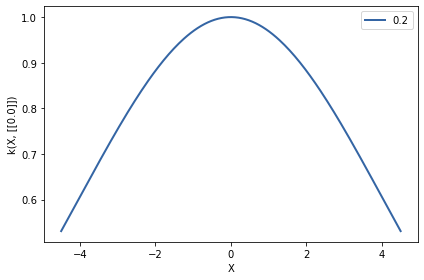

In [5]:
k = GPy.kern.RBF(d)     # By default, the parameters are set to 1.
theta = np.asarray([0.2,0.5,1.,2.,4.])
for t in theta:
    k.lengthscale=t
    k.plot()
plt.legend(theta)

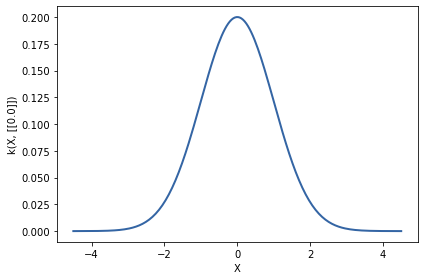

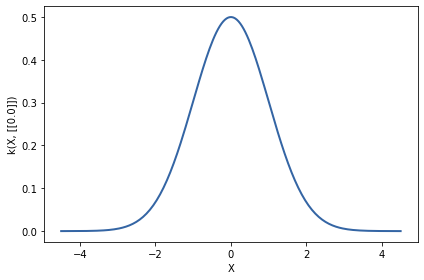

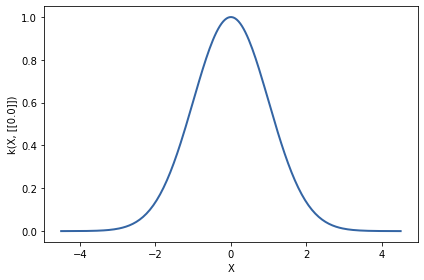

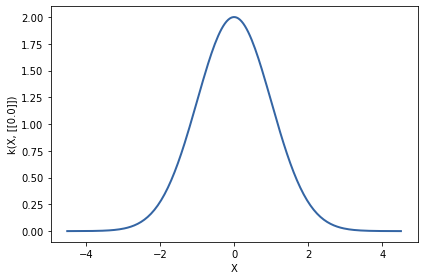

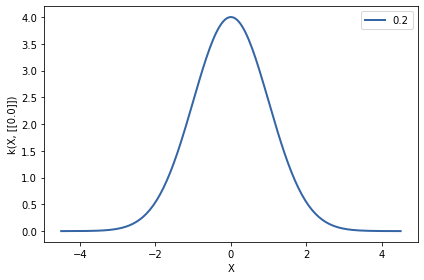

In [6]:
k = GPy.kern.RBF(d)     # By default, the parameters are set to 1.
var = np.asarray([0.2,0.5,1.,2.,4.])
for v in var:
    k.variance=v
    k.plot()
plt.legend(var)

### Exercise 1

a) What is the effect of the lengthscale parameter on the covariance function?

b) Now change the code used above for plotting the covariances associated with the length scale to see the influence of the variance parameter. What is the effect of the the variance parameter on the covariance function?

In [7]:
# Exercise 1 b) This changes the amplitude of the function

## Covariance Functions in GPy

Many covariance functions are already implemented in GPy. Instead of rbf, try constructing and plotting the following  covariance functions: `exponential`, `Matern32`, `Matern52`, `Brownian`, `linear`, `bias`,
`rbfcos`, `periodic_Matern32`, etc. Some of these covariance functions, such as `rbfcos`, are not
parametrized by a variance and a lengthscale. Furthermore, not all kernels are stationary (i.e., they can’t all be written as $k ( x, y) = f ( x − y)$, see for example the Brownian
covariance function). For plotting  so it may be interesting to change the value of the fixed input:

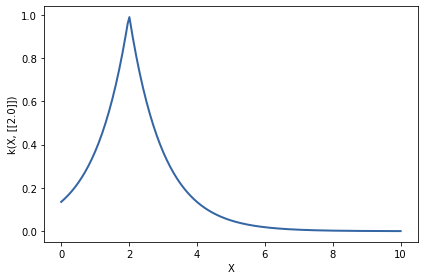

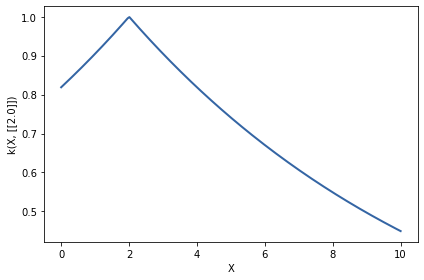

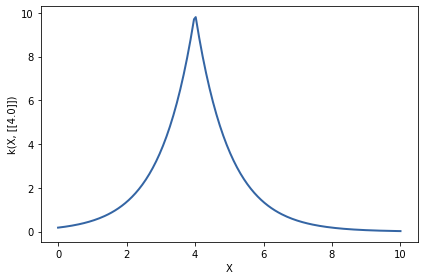

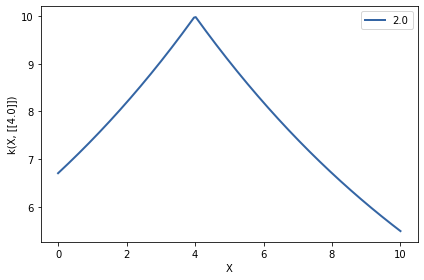

In [8]:
kexp = GPy.kern.Exponential(input_dim=1)
inputs = np.array([2., 4.])
variance = np.array([1, 10])
lengthscale = np.array([1, 10])
for i in range(len(variance)):
    for j in range(len(lengthscale)):
        kexp.variance = variance[i]
        kexp.lengthscale = lengthscale[j]
        kexp.plot(inputs[i],plot_limits=[0,10])
plt.legend(inputs)
# variance determines the amplitude of the function
# lengthscale determines the width of the function and linearity of the function

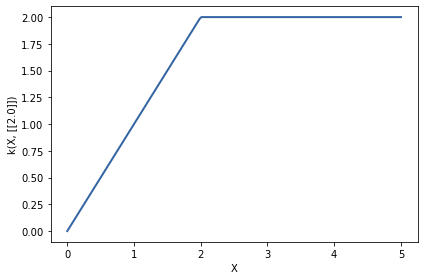

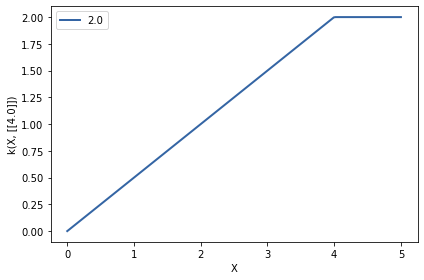

In [9]:
'''
Brownian motion in 1D only.

Negative times are treated as a separate (backwards!) Brownian motion.

:param input_dim: the number of input dimensions
:type input_dim: int
:param variance:
:type variance: float
Init docstring:
The base class for a kernel: a positive definite function
which forms of a covariance function (kernel).
'''
kb = GPy.kern.Brownian(input_dim=1)
inputs = np.array([2., 4.])
for x in inputs:
    kb.plot(x,plot_limits=[0,5])
    kb.variance  = 0.5
plt.legend(inputs)
#plt.ylim(-0.1,5.1)

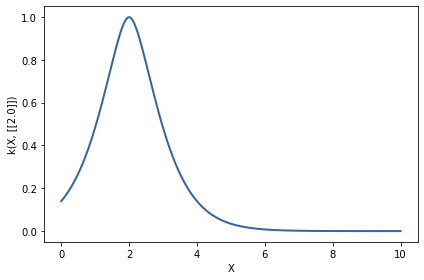

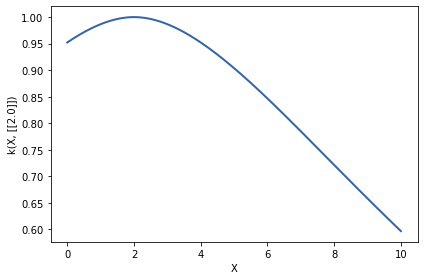

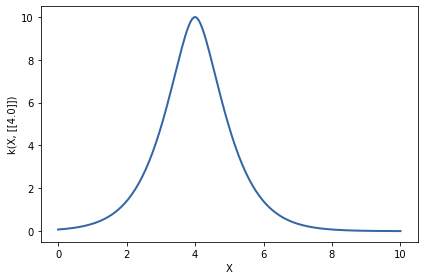

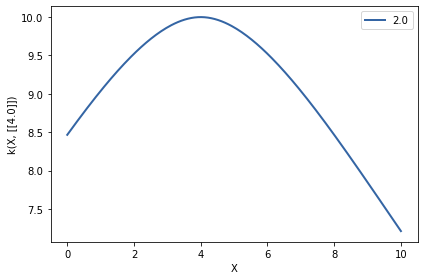

In [10]:
'''
Matern 3/2 kernel:

.. math::

   k(r) = \sigma^2 (1 + \sqrt{3} r) \exp(- \sqrt{3} r) \ \ \ \  \text{ where  } r = \sqrt{\sum_{i=1}^{\text{input_dim}} \frac{(x_i-y_i)^2}{\ell_i^2} }
Init docstring:
The base class for a kernel: a positive definite function
which forms of a covariance function (kernel).
'''
km32 = GPy.kern.Matern32(input_dim=1)
inputs = np.array([2., 4.])
variance = np.array([1, 10])
lengthscale = np.array([1, 10])
for i in range(len(variance)):
    for j in range(len(lengthscale)):
        km32.variance = variance[i]
        km32.lengthscale = lengthscale[j]
        km32.plot(inputs[i],plot_limits=[0,10])
plt.legend(inputs)
# variance determines the amplitude of the function
# lengthscale determines the width of the function

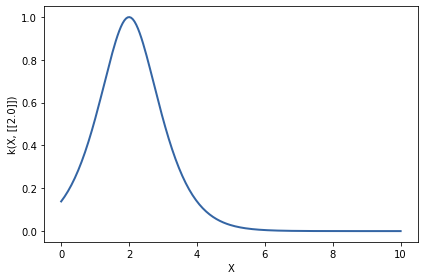

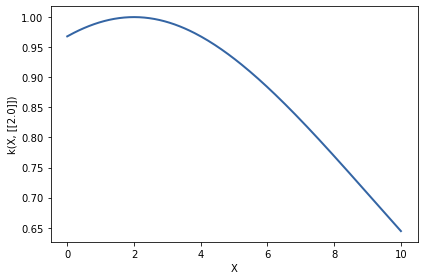

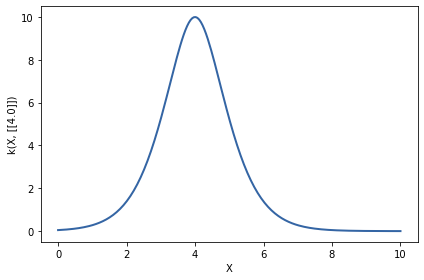

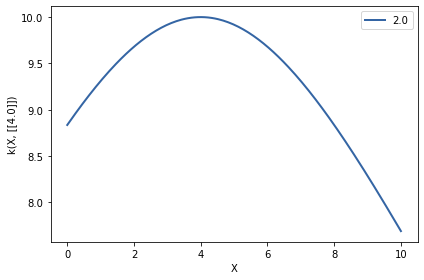

In [11]:
'''
Matern 5/2 kernel:

.. math::

   k(r) = \sigma^2 (1 + \sqrt{5} r + \frac53 r^2) \exp(- \sqrt{5} r)
'''
km52 = GPy.kern.Matern52(input_dim=1)
inputs = np.array([2., 4.])
variance = np.array([1, 10])
lengthscale = np.array([1, 10])
for i in range(len(variance)):
    for j in range(len(lengthscale)):
        km52.variance = variance[i]
        km52.lengthscale = lengthscale[j]
        km52.plot(inputs[i],plot_limits=[0,10])
plt.legend(inputs)

# variance determines the amplitude of the function
# lengthscale determines the width of the function

## Computing the Covariance Function given the Input Data, $\mathbf{X}$

Let $\mathbf{X}$ be a $n$ × $d$ numpy array. Given a kernel $k$, the covariance matrix associated to
$\mathbf{X}$ is obtained with `C = k.K(X,X)` . The positive semi-definiteness of $k$ ensures that `C`
is a positive semi-definite (psd) matrix regardless of the initial points $\mathbf{X}$. This can be
checked numerically by looking at the eigenvalues:

Text(0.5, 1.0, 'Eigenvalues of the Matern 5/2 Covariance')

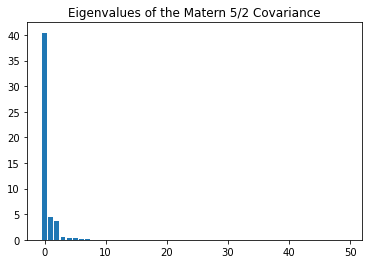

In [12]:
k = GPy.kern.Matern52(input_dim=2)
X = np.random.rand(50,2)       # 50*2 matrix of iid standard Gaussians
C = k.K(X,X)
eigvals = np.linalg.eigvals(C)           # Computes the eigenvalues of a matrix
plt.bar(np.arange(len(eigvals)), eigvals)
plt.title('Eigenvalues of the Matern 5/2 Covariance')

## Combining Covariance Functions

### Exercise 2

a) A matrix, $\mathbf{K}$, is positive semi-definite if the matrix inner product, $\mathbf{x}^\top \mathbf{K}\mathbf{x}$ is greater than or equal to zero regardless of the values in $\mathbf{x}$. Given this it should be easy to see that the sum of two positive semi-definite matrices is also positive semi-definite. In the context of Gaussian processes, this is the sum of two covariance functions. What does this mean from a modelling perspective? 

In [13]:
GPy.kern.RBF?

{'covariance': [[<matplotlib.lines.Line2D at 0x19d4a748730>]]}

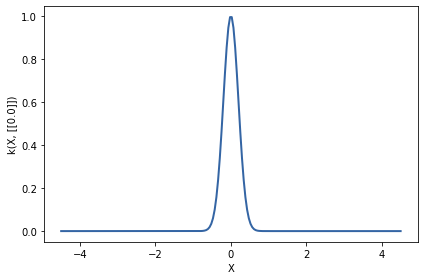

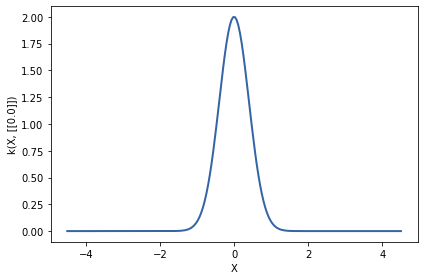

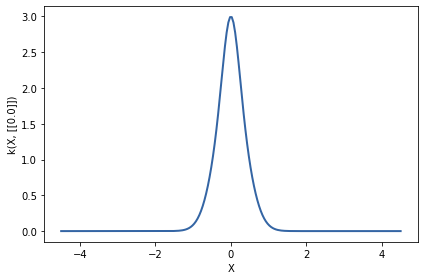

In [14]:
d = 1          # input dimension
var = 1.       # variance
theta = 0.2    # lengthscale
k = GPy.kern.RBF(d) # By default, the parameters are set to 1.
k.variance = var
k.lengthscale = theta
k.plot()
k2 = GPy.kern.RBF(d) # By default, the parameters are set to 1.
k2.variance = var*2
k2.lengthscale = theta*2
k2.plot()
k3 = k+k2
k3.plot(0)

*Hint*: there are actually two related interpretations for this. Think about the properties of a Gaussian distribution, and where the sum of Gaussian variances arises.

What about the element-wise product of two covariance functions? In other words if we define

\begin{align*}
k(\mathbf{x}, \mathbf{x}^\prime) = k_1(\mathbf{x}, \mathbf{x}^\prime) k_2(\mathbf{x}, \mathbf{x}^\prime)
\end{align*}

then is $k(\mathbf{x}, \mathbf{x}^\prime)$ a valid covariance function?

### Combining Covariance Functions in GPy

In GPy you can easily combine covariance functions you have created using the sum and product operators, `+` and `*`. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


{'covariance': [[<matplotlib.lines.Line2D at 0x19d4a4c8190>]]}

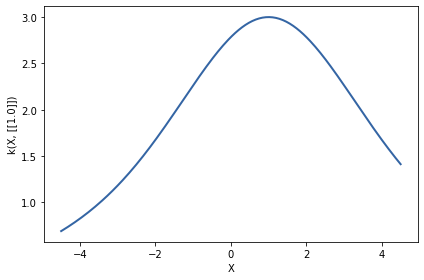

In [15]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)
kern = kern1 + kern2
print(kern)
kern.plot()

Or if we wanted to multiply them we can write

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


{'covariance': [[<matplotlib.lines.Line2D at 0x19d4a9b7fa0>]]}

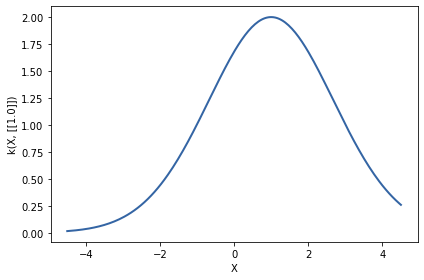

In [16]:
kern = kern1*kern2
print(kern)
kern.plot()

## 2 Sampling from a Gaussian Process

The Gaussian process provides a prior over an infinite dimensional function. It is defined by a covariance *function* and a mean *function*. When we compute the covariance matrix using `kern.K(X, X)` we are computing a covariance *matrix* between the values of the function that correspond to the input locations in the matrix `X`. If we want to have a look at the type of functions that arise from a particular Gaussian process we can never generate all values of the function, because there are infinite values. However, we can generate samples from a Gaussian *distribution* based on a covariance matrix associated with a particular matrix of input locations `X`. If these locations are chosen appropriately then they give us a good idea of the underlying function. For example, for a one dimensional function, if we choose `X` to be uniformly spaced across part of the real line, and the spacing is small enough, we'll get an idea of the underlying function. We will now use this trick to draw sample paths from a Gaussian process. 

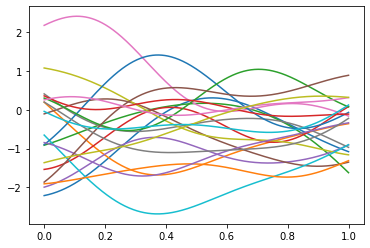

In [25]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.3, variance = 1)

X = np.linspace(0.,1.,500) # define X to be 500 points evenly spaced over [0,1]
X = X[:,None] # reshape X to make it n*p --- we try to use 'design matrices' in GPy 

mu = np.zeros((500)) # vector of the means --- we could use a mean function here, but here it is just zero.
C = k.K(X,X) # compute the covariance matrix associated with inputs X

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

plt.figure()     # open a new plotting window
for i in range(20):
    plt.plot(X[:],Z[i,:])

Our choice of `X` means that the points are close enough together to look like functions. We can see the structure of the covariance matrix we are plotting from if we visualize C.

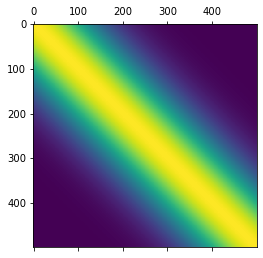

In [37]:
plt.matshow(C)

Now try a range of different covariance functions and values and plot the corresponding sample paths for each using the same approach given above.

In [38]:
# Try plotting sample paths here

### Exercise 3

Can you tell the covariance structures that have been used for generating the
sample paths shown in the figure below?
<br>
<center>
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figa.png" alt="Figure a" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figb.png" alt="Figure b" style="width: 30%;">
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figc.png" alt="Figure c" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figd.png" alt="Figure d" style="width: 30%;">
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/fige.png" alt="Figure e" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figf.png" alt="Figure f" style="width: 30%;">
</center>


## 3 A Gaussian Process Regression Model

We will now combine the Gaussian process prior with some data to form a GP regression model with GPy. We will generate data from the function $f ( x ) = − \cos(\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

In [27]:
np.random.normal?

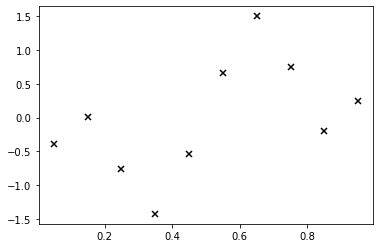

In [78]:
X = np.linspace(0.05,0.95,10)[:,None]
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X) + np.random.normal(loc=0.0, scale=0.1, size=(10,1)) 
plt.figure()
plt.plot(X,Y,'kx',mew=1.5)

A GP regression model based on an exponentiated quadratic covariance function can be defined by first defining a covariance function, 

In [79]:
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

And then combining it with the data to form a Gaussian process model,

In [80]:
m = GPy.models.GPRegression(X,Y,k)

Just as for the covariance function object, we can find out about the model using the command `print m`. 

In [81]:
print(m)


Name : GP regression
Objective : 13.517136165865345
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that by default the model includes some observation noise
with variance 1. We can see the posterior mean prediction and visualize the marginal posterior variances using `m.plot()`.

{'dataplot': [<matplotlib.collections.PathCollection at 0x19d4bf83e50>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x19d4bf91400>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x19d4bf916a0>]}

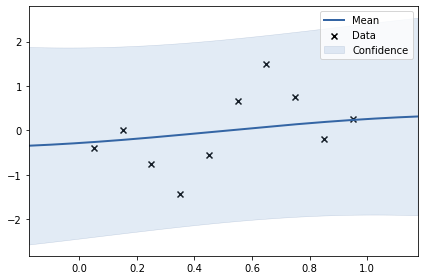

In [82]:
m.plot()

The actual predictions of the model for a set of points `Xstar`
(an $m \times p$ array) can be computed using `Ystar, Vstar, up95, lo95 = m.predict(Xstar)`

### Exercise 4

a) What do you think about this first fit? Does the prior given by the GP seem to be
adapted?

b) The parameters of the models can be modified using a regular expression matching the parameters names (for example `m['noise'] = 0.001` ). Change the values of the parameters to obtain a better fit.

In [94]:
m['Gaussian_noise.variance'] = 0.01
m['rbf.lengthscale'] = 0.01

{'dataplot': [<matplotlib.collections.PathCollection at 0x19d4c0e2580>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x19d4c1efee0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x19d4c1fd1c0>]}

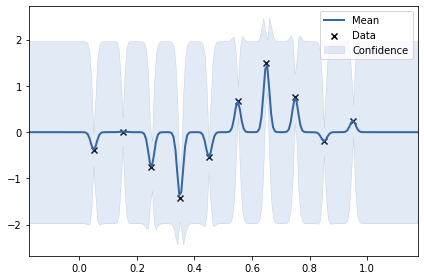

In [95]:
m.plot()

c) As in Section 2, random sample paths from the conditional GP can be obtained using
`np.random.multivariate_normal(mu[:,0],C)` where the mean vector and covariance
matrix `mu`, `C` are obtained through the predict function `mu, C, up95, lo95 = m.predict(Xp,full_cov=True)`. Obtain 10 samples from the posterior sample and plot them alongside the data below.

In [57]:
Xstar = np.linspace(0.05,0.95,100)[:,None]
muStar, Vstar, = m.predict(Xstar, full_cov=True)

In [67]:
Xstar[:,0]

array([0.05      , 0.05909091, 0.06818182, 0.07727273, 0.08636364,
       0.09545455, 0.10454545, 0.11363636, 0.12272727, 0.13181818,
       0.14090909, 0.15      , 0.15909091, 0.16818182, 0.17727273,
       0.18636364, 0.19545455, 0.20454545, 0.21363636, 0.22272727,
       0.23181818, 0.24090909, 0.25      , 0.25909091, 0.26818182,
       0.27727273, 0.28636364, 0.29545455, 0.30454545, 0.31363636,
       0.32272727, 0.33181818, 0.34090909, 0.35      , 0.35909091,
       0.36818182, 0.37727273, 0.38636364, 0.39545455, 0.40454545,
       0.41363636, 0.42272727, 0.43181818, 0.44090909, 0.45      ,
       0.45909091, 0.46818182, 0.47727273, 0.48636364, 0.49545455,
       0.50454545, 0.51363636, 0.52272727, 0.53181818, 0.54090909,
       0.55      , 0.55909091, 0.56818182, 0.57727273, 0.58636364,
       0.59545455, 0.60454545, 0.61363636, 0.62272727, 0.63181818,
       0.64090909, 0.65      , 0.65909091, 0.66818182, 0.67727273,
       0.68636364, 0.69545455, 0.70454545, 0.71363636, 0.72272

In [68]:
# Exercise 4 c) answer
# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(muStar,Vstar,10)

plt.figure()     # open a new plotting window
for i in range(len(Z)):
    plt.plot(Xstar[:,0],Z[i,:])

ValueError: mean must be 1 dimensional

### Covariance Function Parameter Estimation

As we have seen during the lectures, the parameters values can be estimated by maximizing the likelihood of the observations. Since we don’t want one of the variance to become negative during the optimization, we can constrain all parameters to be positive before running the optimisation.

In [80]:
m.constrain_positive()

reconstraining parameters GP_regression


The warnings are because the parameters are already constrained by default, the software is warning us that they are being reconstrained.

Now we can optimize the model using the `m.optimize()` method.


Name : GP regression
Objective : 8.04156832074197
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.7426431521697959  |      +ve      |        
  rbf.lengthscale          |    0.1328694371589679  |      +ve      |        
  Gaussian_noise.variance  |  0.020523663166754864  |      +ve      |        


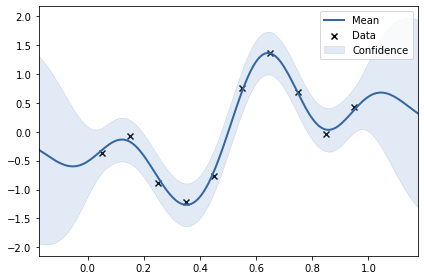

In [82]:
m.optimize()
m.plot()
print(m)

The parameters obtained after optimisation can be compared with the values selected by hand above. As previously, you can modify the kernel used for building the model to investigate its influence on the model.

## 4 A Running Example

Now we'll consider a small example with real world data, data giving the pace of all marathons run at the olympics. To load the data use

In [84]:
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
print(data['details'])

olympicMarathonTimes.csv
[==============================]   0.001/0.001MB                                                
Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data


Text(0, 0.5, 'marathon pace min/km')

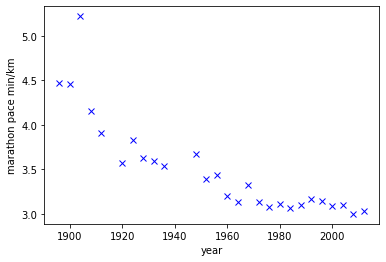

In [85]:
X = data['X']
Y = data['Y']
plt.plot(X, Y, 'bx')
plt.xlabel('year')
plt.ylabel('marathon pace min/km')

### Exercise 5

a) Build a Gaussian process model for the olympic data set using a combination of an exponentiated quadratic and a bias covariance function. Fit the covariance function parameters and the noise to the data. Plot the fit and error bars from 1870 to 2030. Do you think the predictions are reasonable? If not why not?

-6.382545363484866

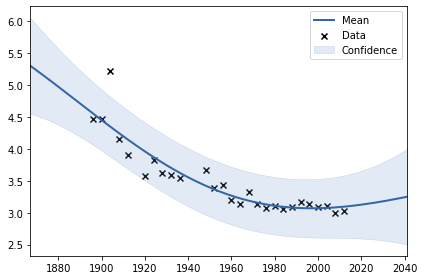

In [86]:
# Exercise 5 a) answer 
kern = GPy.kern.RBF(1) + GPy.kern.Bias(1)
model = GPy.models.GPRegression(X, Y, kern)
model.optimize()
model.plot()# Exercise 5 d) answer
model.log_likelihood()

b) Fit the same model, but this time intialize the length scale of the exponentiated quadratic to 0.5. What has happened? Which of model has the higher log likelihood, this one or the one from (a)? 

*Hint:* use `model.log_likelihood()` for computing the log likelihood.

-25.430027435561875

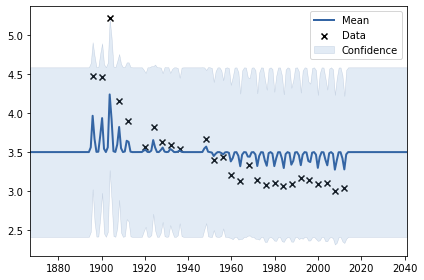

In [98]:
# Exercise 5 b) answer
kern = GPy.kern.RBF(1, lengthscale=0.5) + GPy.kern.Bias(1)
model = GPy.models.GPRegression(X, Y, kern)
model.optimize()
model.plot()# Exercise 5 d) answer
model.log_likelihood()

c) Modify your model by including two covariance functions. Intitialize a covariance function with an exponentiated quadratic part, a Matern 3/2 part and a bias covariance. Set the initial lengthscale of the exponentiated quadratic to 80 years, set the initial length scale of the Matern 3/2 to 10 years. Optimize the new model and plot the fit again. How does it compare with the previous model? 

In [29]:
# Exercise 5 c) answer

d) Repeat part c) but now initialize both of the covariance functions' lengthscales to 20 years. Check the model parameters, what happens now? 

In [30]:
# Exercise 5 d) answer

e) Now model the data with a product of an exponentiated quadratic covariance function and a linear covariance function. Fit the covariance function parameters. Why are the variance parameters of the linear part so small? How could this be fixed?

In [31]:
# Exercise 5 e) answer